<a href="https://colab.research.google.com/github/1uch0/LLM_Udemy_course/blob/main/Sentiment_Analysis_News.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Business Case LLM Powered Sentiment Analyzer for Financial **News**

## Libraries

In [16]:
##Api that calls financial news
!pip install newsapi-python

#API key fro financial new API
from google.colab import userdata
from newsapi import NewsApiClient
API_KEY_News = userdata.get('Finan_News')
from openai import OpenAI

import pandas as pd

## Initialization

In [68]:
# Init API Key for News
newsapi = NewsApiClient(api_key=API_KEY_News)

# Init GTP for sentiment analysis
api_key = userdata.get('Open_AI_API') ##Open_AI_API It is the API key from OPEN_AI saved in collab
openai = OpenAI(api_key=api_key)
openai_api_key = api_key

#Model used for this problem
OPENAI_MODEL = "gpt-4o-mini"

StartDate='2025-04-20'
EndDate='2025-05-07'


## Data Collection

Implement an API call to a financial news API to collect articles on equity markets. You can use NewsAPI which has a python wrapper available making it easy to integrate (https://newsapi.org/docs/client libraries/python ). If you have experience with another service, feel free to use what you prefer.

The goal is to pre process the text data, so it is clean for the LLM API input.

In [83]:
#Financial news
#Focus on US. as part of the keywords
#Focus on equity markets and financial new
#Look for everything

articles = newsapi.get_everything(
    #from_param='2025-04-08',
    from_param=StartDate,
    to=EndDate,
    q='(equity market OR stock market OR NASDAQ OR NYSE OR S&P 500) AND (financial news OR market analysis) AND (USA OR "United States")',
    sort_by='publishedAt',
    language='en'

)


In [84]:
print(articles)

{'status': 'ok', 'totalResults': 117, 'articles': [{'source': {'id': None, 'name': 'GlobeNewswire'}, 'author': 'CoreCivic, Inc.', 'title': 'CoreCivic Reports First Quarter 2025 Financial Results', 'description': 'Increased Occupancy and New Contracts Propel Strong Financial Performance Raises 2025 Full Year Guidance Increased Occupancy and New Contracts Propel Strong Financial Performance Raises 2025 Full Year Guidance', 'url': 'https://www.globenewswire.com/news-release/2025/05/07/3076627/0/en/CoreCivic-Reports-First-Quarter-2025-Financial-Results.html', 'urlToImage': 'https://ml.globenewswire.com/Resource/Download/bfda1f11-c40a-4d35-81b6-04c87c3c29dd', 'publishedAt': '2025-05-07T20:15:00Z', 'content': 'BRENTWOOD, Tenn. , May 07, 2025 (GLOBE NEWSWIRE) -- CoreCivic, Inc. (NYSE: CXW) (CoreCivic or the Company) announced today its first quarter 2025 financial results.\xa0\xa0\r\nFinancial Highlights First Quar… [+39348 chars]'}, {'source': {'id': None, 'name': 'GlobeNewswire'}, 'author':

In [71]:
#Organized them chronologically from oldest to newest
articles['articles'].sort(key=lambda x: x['publishedAt'])

print(articles)

#Print the articles in a more readable format

for article in articles['articles']:
  print("Title:", article['title'])
  print("Description:", article['description'])
  print("URL:", article['url'])
  print("Published At:", article['publishedAt'])

{'status': 'ok', 'totalResults': 117, 'articles': [{'source': {'id': None, 'name': 'ETF Daily News'}, 'author': 'MarketBeat News', 'title': 'Royal Bank of Canada Issues Positive Forecast for Atkore (NYSE:ATKR) Stock Price', 'description': 'Atkore (NYSE:ATKR – Free Report) had its price objective increased by Royal Bank of Canada from $64.00 to $65.00 in a research note issued to investors on Tuesday,Benzinga reports. The brokerage currently has a sector perform rating on the stock. A number of …', 'url': 'https://www.etfdailynews.com/2025/04/23/royal-bank-of-canada-issues-positive-forecast-for-atkore-nyseatkr-stock-price/', 'urlToImage': 'https://www.americanbankingnews.com/wp-content/timthumb/timthumb.php?src=https://www.marketbeat.com/logos/atkore-inc-logo.png?v=20221220081321&w=240&h=240&zc=2', 'publishedAt': '2025-04-23T07:37:00Z', 'content': 'Atkore (NYSE:ATKR – Free Report) had its price objective increased by Royal Bank of Canada from $64.00 to $65.00 in a research note issued t

## Sentiment Analysis

In [72]:
#Function to build the prompt for ChatGPT with the given instructions

def build_prompt(text):
    return f"""
You are a financial news analyst. Analyze the following news article for sentiment specifically about *recession fears* similar to an economys reading the article.
You have to focus on economys health from the context of the news presented (i.e. recesion fears in the US)
A positive score will mean that the fear of recession is present while a negative score will mean that we are recession safe.
Onlye respond with:
Sentiment: Positive (fear), Neutral, or Negative (no fear)
Confidence (0–100): <confidence score>

Article:
{text}
"""


In [73]:
#Function that gives back the sentiment analysis from the given text

def get_sentiment_from_llm(article_text):
    prompt = build_prompt(article_text)

    response = stream = openai.chat.completions.create(
        model=OPENAI_MODEL,  # gpt4 mini
        messages=[{"role": "user", "content": prompt}],
        temperature=0.2, # Controls randomness (lower = more deterministic, higher = more creative).
        max_tokens=80, #80 tokens are enough for a sentiment label
    )

    return response.choices[0].message.content.strip()

In [74]:
#This function linkes both the title and the description of the articles

def format_article(title, description):
    return f"Title: {title}\nDescription: {description}"

In [75]:
#This function is in charge of mapping the positive, neutral and negative sentimens into numbers: 1, -1, 0.
#It will return the sentiment value and the confidence

def parse_sentiment(sentiment_result):
    # Define sentiment map
    sentiment_map = {
        "positive": 1,
        "neutral": 0,
        "negative": -1
    }

    # Split the sentiment_result into lines
    lines = sentiment_result.strip().splitlines()

    # Extract sentiment label and clean it (removing any extra information like '(fear)')
    sentiment_label = lines[0].split(":")[1].strip().split()[0].lower()  # Take the first word of the sentiment
    confidence = float(lines[1].split(":")[1].strip()) / 100  # normalize confidence to 0-1

    # Map sentiment to numeric value
    sentiment_value = sentiment_map.get(sentiment_label, 0)  # Default to 0 for unknown labels

    return sentiment_value, confidence #If I have this "Sentiment: Positive (fear)\nConfidence (0–100): 75". It will return this (1, 0.75)

In [76]:
#TEST FOR PRINTING TITLE AND DESCRIPTION OF THE ARTICLES
#print(articles['articles'][0]['title'])
#print(articles['articles'][0]['description'])

#Data frame to store date and sentiment data: Matrix that contains: Formated Date + Numerical Sentiment

data = []
for article in articles['articles']:
  #I get article Title and Description
  article_text = format_article(article['title'], article['description'])
  #I get the sentiment result from the GTP prompt
  sentiment_result = get_sentiment_from_llm(article_text)
  #I extract just day-month-year information from date
  date = article['publishedAt'].split('T')[0]
  #print(article['publishedAt'].split('T')[0], parse_sentiment(sentiment_result))

  #I convert into a tuple both the date and sentiment result and convert the values in 1:Positive (fear); 0 Neutral AND -1 (negative)
  sentiment_tuple = parse_sentiment(sentiment_result)  # e.g., (1, 0.75)
  data.append((date, sentiment_tuple)) #I keep adding the results into a List


# I create DataFrame with one column for date and one for the tuple
df = pd.DataFrame(data, columns=["date", "sentiment_data"])

# Step 2: Split the tuple into two new columns: sentiment and confidence
df[['sentiment', 'confidence']] = pd.DataFrame(df['sentiment_data'].tolist(), index=df.index)
#print(parse_sentiment(sentiment_result))


print(df)

          date sentiment_data  sentiment  confidence
0   2025-04-23       (0, 0.6)          0        0.60
1   2025-04-23      (1, 0.75)          1        0.75
2   2025-04-23      (1, 0.75)          1        0.75
3   2025-04-24       (0, 0.5)          0        0.50
4   2025-04-24       (0, 0.5)          0        0.50
..         ...            ...        ...         ...
93  2025-05-07       (0, 0.5)          0        0.50
94  2025-05-07       (0, 0.5)          0        0.50
95  2025-05-07       (0, 0.5)          0        0.50
96  2025-05-07       (0, 0.6)          0        0.60
97  2025-05-07     (-1, 0.75)         -1        0.75

[98 rows x 4 columns]


In [77]:
##Now all the data of the same date has to be aggregated.

# First, create a weighted sentiment score per article
df['weighted_sentiment'] = df['sentiment'] * df['confidence']

# Then group by date and calculate the weighted average sentiment per day
daily_sentiment = df.groupby('date').apply(
    lambda x: x['weighted_sentiment'].sum() / x['confidence'].sum()
)

# Then I convert the result to a data frame
daily_sentiment_df = daily_sentiment.reset_index(name='daily_sentiment_score')

print(daily_sentiment_df)

          date  daily_sentiment_score
0   2025-04-23               0.714286
1   2025-04-24               0.137615
2   2025-04-25               0.306122
3   2025-04-26               0.333333
4   2025-04-27               0.151515
5   2025-04-28               0.168539
6   2025-04-29               0.500000
7   2025-04-30               0.428571
8   2025-05-01              -0.186813
9   2025-05-02               0.861111
10  2025-05-03               0.540230
11  2025-05-04               0.000000
12  2025-05-05               0.129771
13  2025-05-06               0.131313
14  2025-05-07               0.000000


<ipython-input-77-cba80cdb94cb>:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_sentiment = df.groupby('date').apply(


## Showing the Results

In [78]:
import pandas_datareader.data as web
import pandas as pd

# Define date range
start_date = StartDate
end_date = EndDate

# Fetch S&P 500 data from Stooq
sp500 = web.DataReader('^SPX', 'stooq', start=start_date, end=end_date)

# Reset index and sort
sp500 = sp500.reset_index()
sp500['date'] = pd.to_datetime(sp500['Date'])
sp500 = sp500.sort_values('date')[['date', 'Close']].rename(columns={'Close': 'sp500_close'})

# Calculate daily percentage return (in %)
sp500['sp500_return_percent'] = sp500['sp500_close'].pct_change() * 100

# Drop first row (NaN in return)
sp500 = sp500.dropna()

# Set the full date range between start and end date
full_date_range = pd.date_range(start=start_date, end=end_date)

# Reindex to include all dates, filling missing values with 0
sp500 = sp500.set_index('date').reindex(full_date_range, fill_value=0).reset_index()

# Rename columns
sp500 = sp500.rename(columns={'index': 'date', 'sp500_return_percent': 'percentage_return'})

# Print the data with both date and percentage return
print(sp500[['date', 'percentage_return']])


         date  percentage_return
0  2025-04-20           0.000000
1  2025-04-21           0.000000
2  2025-04-22           2.511729
3  2025-04-23           1.666112
4  2025-04-24           2.025908
5  2025-04-25           0.737314
6  2025-04-26           0.000000
7  2025-04-27           0.000000
8  2025-04-28           0.064070
9  2025-04-29           0.580240
10 2025-04-30           0.147999
11 2025-05-01           0.629909
12 2025-05-02           1.472661
13 2025-05-03           0.000000
14 2025-05-04           0.000000
15 2025-05-05          -0.638159
16 2025-05-06          -0.769329
17 2025-05-07           0.434642


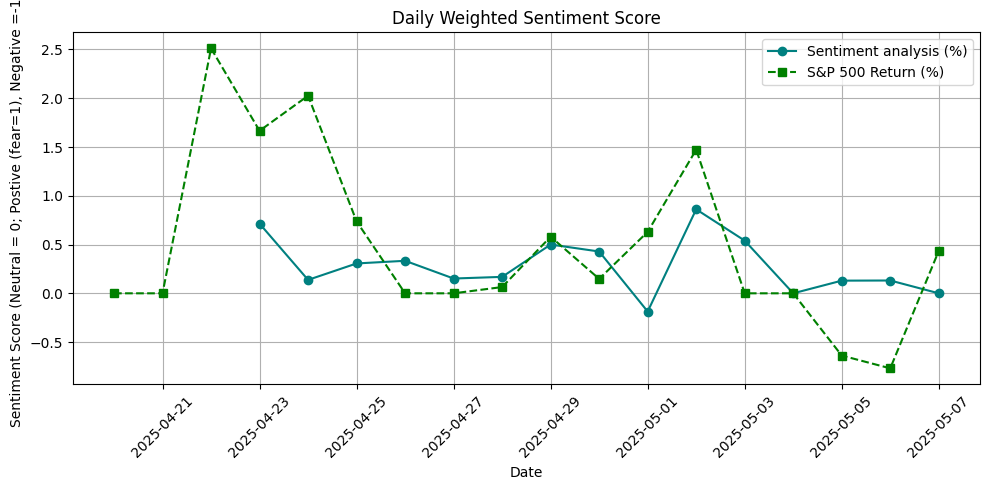

In [80]:
import matplotlib.pyplot as plt

# Convert string dates to datetime
daily_sentiment_df['date'] = pd.to_datetime(daily_sentiment_df['date'])

# Sort by date to ensure correct plotting order
daily_sentiment_df = daily_sentiment_df.sort_values('date')

# Plot
plt.figure(figsize=(10, 5))
plt.plot(
    daily_sentiment_df['date'],
    daily_sentiment_df['daily_sentiment_score'],
    marker='o',
    linestyle='-',
    color='teal',
    label='Sentiment analysis (%)'
)


# Plot S&P 500 return percentage from sp500
plt.plot(
    sp500['date'],
    sp500['percentage_return'],
    marker='s',
    linestyle='--',
    color='green',
    label='S&P 500 Return (%)'
)

# Labels and title
plt.title('Daily Weighted Sentiment Score')
plt.xlabel('Date')
plt.ylabel('Sentiment Score (Neutral = 0; Postive (fear=1), Negative =-1) ')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Add legend
plt.legend()

# Show the plot
plt.show()